In [29]:
from pandasai.connectors import PostgreSQLConnector
from pandasai.llm import OpenAI
from pandasai.llm.local_llm import LocalLLM
from pandasai import Agent
import os
import sys

sys.path.append('../')

from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import END, StateGraph


In [30]:
# define llms for pandasAI
ollama_llm = LocalLLM(api_base="http://localhost:11434/v1", model="llama3")
openai_llm_4o = OpenAI(
    api_token=os.environ.get('openai_api_key'),
    model="gpt-4o",
)
openai_llm_gpt4 = OpenAI(
    api_token=os.environ.get('openai_api_key'),
    model="gpt-4",
)
openai_llm_gpt35 = OpenAI(
    api_token=os.environ.get('openai_api_key'),
    model="gpt-3.5-turbo",
)
openai_llm_40_mini = OpenAI(
    api_token=os.environ.get('openai_api_key'),
    model="gpt-4o-mini",
)

In [31]:
# define llm for langgraph
from langchain_openai import ChatOpenAI
openai_api_key = os.environ.get("openai_api_key")
llm = ChatOpenAI(model="gpt-3.5-turbo", openai_api_key=openai_api_key)

In [32]:
class State(TypedDict):  # If necessary, adapt the state
    messages: Annotated[list[AnyMessage], add_messages]

In [33]:
def welcome_agent(state: State):
    system_message = SystemMessage(
        content="You are a primary assistant, your job is to only select the sub-assistant to handle the user query. There are three sub-assistants available: FlightSearchAssistant and HotelSearchAssistant and Hello. If the user says bye, return END. Please select one of them as output string")
    data = llm.invoke([system_message] + state["messages"])
    return {"messages": [data]}

In [34]:
def query_hotel_db(query: str):
    employees_df_postgres = PostgreSQLConnector(
    config={
        "host": "localhost",
        "port": 5432,
        "database": "postgres",
        "username": "checkito950",
        "password": "123456",
        "table": "hotel_information",
    })
    agent = Agent([employees_df_postgres], config={"llm": openai_llm_gpt4, "max_retries": 3, "verbose": True})
    return agent.chat(query)

def search_hotel_by_user_query(state: State):
    query = state["messages"][-2].content
    result = query_hotel_db(query)
    
    if result is None:
        return {"messages": "Sorry, I could not find any information about the hotel"}
    return {"messages": str(result)}

In [35]:
def query_flight_db(query: str):
    employees_df_postgres = PostgreSQLConnector(
    config={
        "host": "localhost",
        "port": 5432,
        "database": "postgres",
        "username": "checkito950",
        "password": "123456",
        "table": "flights",
    })
    agent = Agent([employees_df_postgres], config={"llm": openai_llm_gpt4, "max_retries": 3, "verbose": True})
    return agent.chat(query)

def search_flight_by_user_query(state: State):
    query = state["messages"][-2].content
    result = query_flight_db(query)
    
    if result is None:
        return {"messages": "Sorry, I could not find any information about the flight"}
    return {"messages": str(result)}

In [36]:
def get_user_input(state: State):
    response_message_before = state["messages"][-1].content
    user_input = input(f"{response_message_before} \n Enter your query: ")
    return {"messages": [HumanMessage(content=user_input)]}

In [37]:
def route_to_sub_assistant(state: State):
    if state["messages"][-1].content == "HotelSearchAssistant":
        return "search_hotel"
    elif state["messages"][-1].content == "FlightSearchAssistant":
        return "search_flight"
    elif state["messages"][-1].content == "Hello":
        return "get_user_input"
    return END

In [38]:
my_graph = StateGraph(State)
my_graph.set_entry_point("welcome-agent")

my_graph.add_node("welcome-agent", welcome_agent)
my_graph.add_node("search_hotel", search_hotel_by_user_query)
my_graph.add_node("search_flight", search_flight_by_user_query)
my_graph.add_node("get_user_input", get_user_input)

my_graph.add_conditional_edges("welcome-agent", route_to_sub_assistant)
my_graph.add_edge("search_flight", "get_user_input")
my_graph.add_edge("search_hotel", "get_user_input")
my_graph.add_edge("get_user_input", "welcome-agent")


In [39]:
app = my_graph.compile()

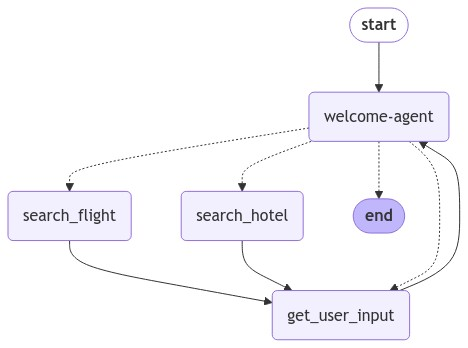

In [40]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

2024-11-14 11:26:22 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-14 11:27:02 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-14 11:27:02 [INFO] Question: I want to book a flight from Munich to New York. Show me all the flight with departure time before 10 which is executed by Lufthansa
2024-11-14 11:27:02 [INFO] Running PandasAI with openai LLM...
2024-11-14 11:27:02 [INFO] Prompt ID: e6db268c-f590-4123-ac54-baef193b06b6
2024-11-14 11:27:02 [INFO] Executing Pipeline: GenerateChatPipeline
2024-11-14 11:27:02 [INFO] Executing Step 0: ValidatePipelineInput
2024-11-14 11:27:02 [INFO] Executing Step 1: CacheLookup
2024-11-14 11:27:02 [INFO] Executing Step 2: PromptGeneration
2024-11-14 11:27:05 [INFO] Querying without using training data.
2024-11-14 11:27:05 [INFO] Querying without using training docs.
2024-11-14 11:27:05 [INFO] Using prompt: <dataframe name="flights">
dfs[0]:10x9
from_city,to_c

{'messages': [HumanMessage(content='Hello', id='6f8d87e8-81dd-4840-bb81-c4773fd5a0a6'),
  AIMessage(content='Hello', response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 70, 'total_tokens': 71, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d4f7d830-e9db-4286-8e1d-d909feaa1c55-0', usage_metadata={'input_tokens': 70, 'output_tokens': 1, 'total_tokens': 71}),
  HumanMessage(content='I want to book a flight from Munich to New York. Show me all the flight with departure time before 10 which is executed by Lufthansa', id='d2e47888-3f54-4dc9-9f70-d9ed82712964'),
  AIMessage(content='FlightSearchAssistant', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 110, 'total_tokens

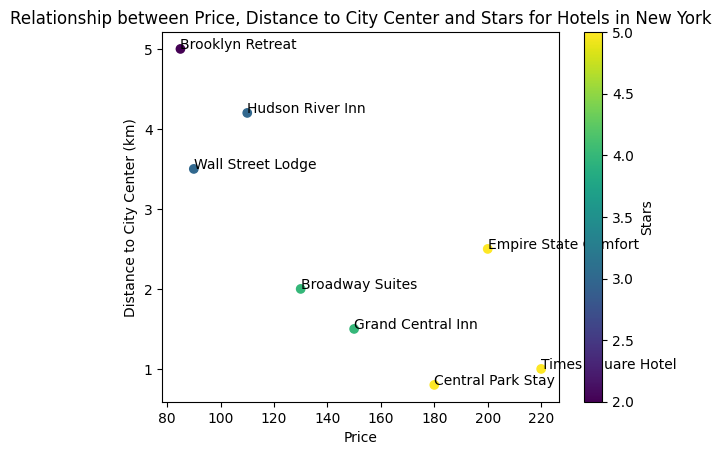

In [41]:
app.invoke(
    {"messages": [HumanMessage(content="Hello")]
     }
)